In [2]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn import manifold
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [144]:
rc = Client()

In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [4]:
def compute_inv_shrunk_covariance(x,mask):
    #see http://www.diedrichsenlab.org/pubs/Walther_Neuroimage_2016.pdf
    t,n = x.shape #t measurements by n voxels

    #demean
    x = x - x.mean(0)

    #compute covariance
    sample = (1.0/t) * np.dot(np.transpose(x),x)

    #copute prior
    prior = np.diag(np.diag(sample))

    #compute shrinkage
    d = 1.0/n * np.linalg.norm(sample - prior,ord = 'fro')**2
    y = np.square(x)
    r2 = 1.0/n/t**2 * np.sum(np.sum(np.dot(np.transpose(y),y)))- \
    1.0/n/t*np.sum(np.sum(np.square(sample)))

    #compute the estimator
    shrinkage = max(0,min(1,r2/d))
    sigma = shrinkage*prior + (1-shrinkage)*sample

    #compute the inverse
    try:
        inv_sigma = np.linalg.inv(sigma)
    except numpy.linalg.linalg.LinAlgError as err:
        if 'Singular matrix' in err.message:
            inv_sigma = np.linalg.inv(prior) #univariate
        else:
            raise
    
    return inv_sigma

In [29]:
#project a onto be
def vector_reject(a,b): #a gives variance to be
    return a - (np.dot(a,b)/np.dot(b,b)) * b    

In [30]:
#make sure MTL masks are exclusive
def trim_mask(sub,mask,m):
    exclusions = overlap_masks[:]
    exclusions.remove(m)

    m1 = op.join(home_dir,'data', sub,  'masks', exclusions[0] +'.nii.gz')
    m1 = nib.load(m1).get_data().astype(bool)

    m2 = op.join(home_dir,'data', sub,  'masks', exclusions[1] +'.nii.gz')
    m2 = nib.load(m2).get_data().astype(bool)

    bad = np.logical_or(m1,m1)
    good = np.invert(bad)

    mask = np.logical_and(mask,good)
    return mask

In [31]:
def compute_inverse_sigma(sub,exp,smooth,masks):
    sub_path = op.join(home_dir,'analysis', exp, sub, 'reg','epi', smooth)
    for run in map(str,range(1,4)):
        res = op.join(sub_path, 'run_'  + run,'res4d_xfm.nii.gz')

        if op.exists(res):
            res = nib.load(res).get_data().astype(float)

            for m in masks:
                out_f = op.join(home_dir,'covariance','_'.join([exp,sub,smooth,run,m]) + '.txt')
                
                if not op.exists(out_f): #don't recompute
                    mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
                    mask = nib.load(mask).get_data().astype(bool)
                    if m in overlap_masks:
                        mask = trim_mask(sub,mask,m)

                    x = res[mask]
                    x = np.transpose(x)

                    inv_sigma = compute_inv_shrunk_covariance(x,m)

                    inv_sigma = scipy.linalg.fractional_matrix_power(inv_sigma,.5) #take square root

                    np.savetxt(out_f,inv_sigma)


In [121]:
def delete_inverse_sigma(sub,exp,smooth,masks):
    for run in map(str,range(1,4)):
        for m in masks:
            out_f = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')
            if op.exists(out_f):
                os.remove(out_f)

In [122]:
def get_condition(i,single):
    if single:
        return cond_map[i], 1
    elif i < 11:
        cond = 'b_plus'
        trial = i
    elif i < 21:
        cond = 'c_plus'
        trial = i - 10
    elif i < 31:
        cond = 'c_minus'
        trial = i - 20
    elif i < 41:
        cond = 'b_minus'
        trial = i - 30
    return cond,trial

In [123]:
def extract_betas(sub,exp,smooth,masks,single = True):
    if single:
        nbetas = 4
    else:
        nbetas = 40
        exp_id = 'sim_4mm-betas'
            
    all_betas = []
    for m in masks:
        out_f = op.join(home_dir,'betas', '_'.join([exp_id,sub,smooth,m]) + '.csv')
        
        #extract saved betas
        if not op.exists(out_f):
            betas = {'sub':[],'mask':[],'run':[],'condition':[],'value':[],'trial':[],'voxel':[],'row':[]}
            sub_path = op.join(home_dir,'analysis', exp_id, sub, 'reg','epi', smooth )

            mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
            mask = nib.load(mask).get_data().astype(bool)
            if m in overlap_masks:
                mask = trim_mask(sub,mask,m)


            for run in map(str,range(1,4)):
                run_dir = op.join(sub_path, 'run_'  + run)

                if os.path.exists(run_dir):

                    for i in range(1,nbetas + 1):
                        f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'

                        cond, trial = get_condition(i,single)

                        #load stat image
                        stat = nib.load(f).get_data().astype(float)
                        stat = stat[mask]

                        for n,val in enumerate(stat):
                            betas['voxel'].append(n)                        
                            betas['sub'].append(sub)
                            betas['value'].append(val)
                            betas['mask'].append(m)
                            betas['run'].append(run)
                            betas['condition'].append(cond)
                            betas['trial'].append(trial)
                            betas['row'].append(i)
                else:
                    print run_dir

            betas = pd.DataFrame(betas)
            betas.to_csv(out_f,index = False)
            
        else: #load from disk
            betas = pd.read_csv(out_f)
            
        all_betas.append(betas)
    all_betas = pd.concat(all_betas)
    all_betas = all_betas.set_index(['sub', 'run','mask','condition','trial'])
    return all_betas

In [124]:
def prewhiten_betas(old_betas,sub,exp,smooth,masks,single = True):
    
    all_betas = []
    if not single:
        exp_id = 'sim_4mm-betas'
        
    for m in masks:
        out_f = op.join(home_dir,'betas', 'whitened','_'.join([exp_id,sub,smooth,m]) + '.csv')
        
        if op.exists(out_f):
            all_betas.append(pd.read_csv(out_f))
            
        else:
            betas = old_betas.xs(m, level='mask', axis=0)
            
            for run in map(str,range(1,4)):
                #load covariance
                inv_sigma = op.join(home_dir,'covariance','_'.join([exp,sub,smooth,run,m]) + '.txt')
                if op.exists(inv_sigma):
                    inv_sigma = np.loadtxt(inv_sigma)

                    for cond in conds:
                        for trial in range(1,11):
                            vals = betas.loc[(sub,int(run),cond,trial),'value'].values
                            whiten_vals = np.dot(inv_sigma,vals)
                            betas.loc[(sub,int(run),cond,trial),'value'] = whiten_vals
                else:
                    print 'no covariance file',inv_sigma
                    
            out_betas = pd.DataFrame(betas.to_records()) 
            out_betas['mask'] = m
            out_betas.to_csv(out_f,index = False)
            all_betas.append(out_betas)
        
    all_betas = pd.concat(all_betas)
    all_betas = all_betas.set_index(['sub', 'run','mask','condition','trial'])
    return all_betas

In [12]:
# sub = 'fd_104'
# run = '2'
# m = 'hipp'
# inv_sigma = op.join(home_dir,'covariance','_'.join(['sim_4mm-onebeta',sub,run,m]) + '.txt')
# inv_sigma = np.loadtxt(inv_sigma)

In [13]:
# # print np.random.shuffle(np.transpose(inv_sigma))
# q = inv_sigma[:, np.random.permutation(inv_sigma.shape[1])]
# sns.heatmap(q[300:400,300:400],vmin = -.0005, vmax = .0005)

In [14]:
def compute_rsa_betas(sub,exp,masks,betas):
    rsa_df = {'cond1':[],'cond2':[],'corr':[],'mask':[],'run':[],'sub':[]}
    runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index))) #get runs
    
    for m in masks:
        
        for i in range(1,nconds+1):
            for j in range(1,nconds+1):
                
                if i<= j:
                    for trial1 in range(1,11):
                        for trial2 in range(1,11):

                            if i !=j or trial1 < trial2:
                                for run in runs:
                                    b1 = betas.loc[(sub,run,m,cond_map[i],trial1),'value'].values
                                    b2 = betas.loc[(sub,run,m,cond_map[j],trial2),'value'].values

                                    distance = scipy.stats.pearsonr(b1,b2)[0]

                                    rsa_df['mask'].append(m)
                                    rsa_df['sub'].append(sub)
                                    rsa_df['cond1'].append(name_map[cond_map[i]] + str(trial1-1))
                                    rsa_df['cond2'].append(name_map[cond_map[j]] + str(trial2-1))
                                    rsa_df['corr'].append(distance)        
                                    rsa_df['run'].append(run)        
    return pd.DataFrame(rsa_df)


In [55]:
def run_sub(sub):
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim.pkl')

    if True:#not op.exists(out_f):

#         compute_inverse_sigma(sub,exp,smooth,masks)
        betas = extract_betas(sub,exp,smooth,masks,False)
        betas = prewhiten_betas(betas,sub,exp,smooth,masks,False)
#         delete_inverse_sigma(sub,exp,smooth,masks) #save disk space

        rsas = compute_rsa_betas(sub,exp,masks,betas)

        #write rsa to a file in case we have to stop the script
        output = open(out_f, 'wb')
        pickle.dump(rsas, output)
        output.close()

In [13]:
overlap_masks = ['peri_sim','para_sim','hipp']
masks = ['V1_V2','hipp','peri_sim','para_sim']
exp = 'sim_4mm-betas'
smooth = 'smoothed'
conds = ['b_plus','b_minus','c_plus','c_minus']
name_map = {'b_plus':'AB+_', 'c_minus':'AC-_','b_minus':'B-_','c_plus':'C+_'}
cond_map = {1:'b_plus',2:'c_minus',3:'b_minus',4:'c_plus'}
nconds = len(cond_map.keys())

In [14]:
# dview = rc[0:16]
# dview.block = True

# dview.push(dict(home_dir=home_dir,
#                 masks = masks,
#                 exp = exp,
#                 conds = conds,
#                 smooth = smooth,
#                 cond_map = cond_map,
#                 name_map = name_map,
#                 nconds = nconds,
#                 get_condition = get_condition,
#                 overlap_masks = overlap_masks,
#                 prewhiten_betas = prewhiten_betas,
#                 compute_inv_shrunk_covariance = compute_inv_shrunk_covariance,
#                 compute_inverse_sigma = compute_inverse_sigma,
#                 extract_betas = extract_betas,
#                 delete_inverse_sigma = delete_inverse_sigma,
#                 trim_mask = trim_mask,
#                 compute_rsa_betas = compute_rsa_betas
#                 ))
# dview.execute("import numpy as np")
# dview.execute("import os.path as op")
# dview.execute("import nibabel as nib")
# dview.execute("import pandas as pd")
# with dview.sync_imports():
#     import os
#     import numpy
#     import scipy
#     import scipy.stats
#     import pickle
# dview.map_sync(run_sub,subs)

# Load and visualize RSA data

In [15]:
#load RSAs from disk
all_rsas = []
for sub in subs:
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim.pkl')
    pkl_file = open(out_f, 'rb')
    rsa = pickle.load(pkl_file)
    all_rsas.append(rsa)
all_rsas = pd.concat(all_rsas)

In [16]:
#add in diagonal elements
new_df = pd.DataFrame()
for sub in subs:
    runs = set(all_rsas.loc[all_rsas['sub'] == sub,'run'])
    for m in masks:
        for run in runs:
            for cond in ['AB+_','B-_','AC-_','C+_']:
                for i in range(10):
                    row = pd.DataFrame({'mask':m,
                                       'sub':sub,
                                        'run':run,
                                        'cond1':cond + str(i),
                                        'cond2':cond + str(i),
                                        'corr': 1.0}, index = [0])
                    new_df = new_df.append(row)
fig_rsas = pd.concat([all_rsas, new_df])

In [17]:
fig_rsas.to_csv('/home/iballard/Dropbox/fd/rsa.csv',index = False)

In [18]:
fig_rsas = fig_rsas.set_index(['mask','run','sub'])

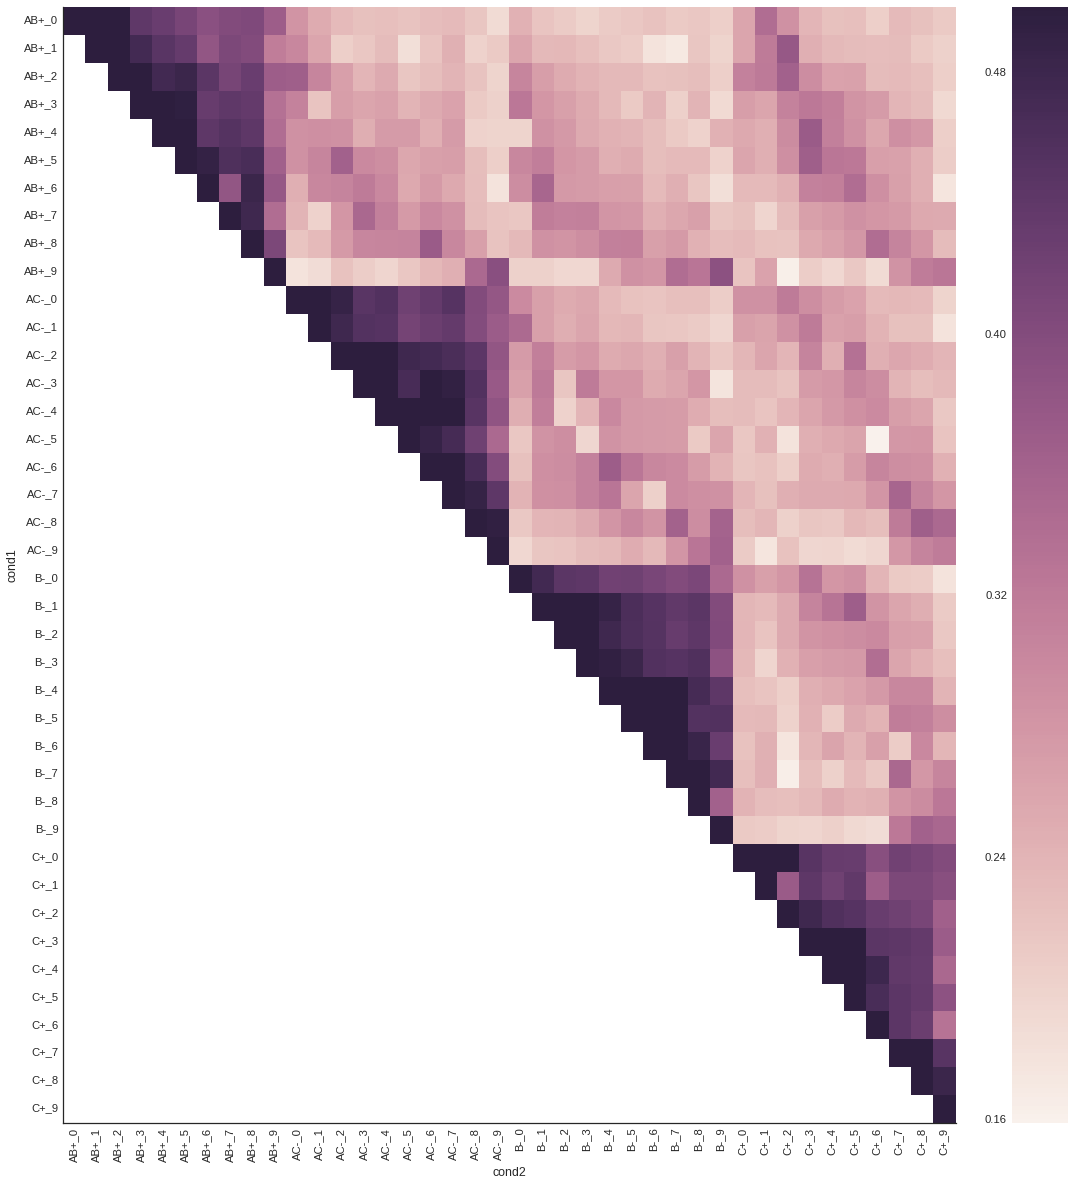

In [254]:
roi = 'hipp'
run = 2
plt.title('')
sns.set_context('paper',font_scale = 1.4,rc={"figure.figsize": (20, 20)})
sns.set_style("white")

mean_rsa = fig_rsas.loc[roi,run].groupby(['cond1','cond2']).mean()
mean_rsa = mean_rsa.unstack()['corr']
sns.heatmap(mean_rsa, vmax = .5)
sns.despine()

plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/' + roi + '.svg',dpi = 600)

# Load results of RL modeling

In [24]:
RL_next = pd.read_csv('/home/iballard/fdPE_V_nexttrial.csv')
RL_next = RL_next[RL_next['condition'] != 'feedback']
RL_next = RL_next.set_index(['exp','sub','run','condition'])
RL_next = RL_next.loc[('sim','fd_104')]

RL_std = pd.read_csv('/home/iballard/fdPE_V_trial.csv')
RL_std = RL_std[RL_std['condition'] != 'feedback']
RL_std = RL_std.set_index(['exp','sub','run','condition'])
RL_std = RL_std.loc[('sim','fd_104')]

for i in range(1,4):
    RL_std.loc[i,'trial'] = range(0,40)
RL_std.loc[(2,'c_plus')]

PE  duration  feedback_valence    onset  rew   rt  \
run condition                                                            
2   c_plus    -1.000000         0               NaN   17.013    0  NaN   
    c_plus    -0.600000         0               NaN   34.034    0  NaN   
    c_plus     1.640000         0               NaN   43.041    1  NaN   
    c_plus     0.984000         0               NaN  117.322    1  NaN   
    c_plus     0.590400         0               NaN  143.957    1  556   
    c_plus     0.354240         0               NaN  158.970    1  452   
    c_plus     0.212544         0               NaN  238.049    1  690   
    c_plus     0.127526         0               NaN  302.728    1  578   
    c_plus     0.076516         0               NaN  319.748    1  600   
    c_plus    -1.954090         0               NaN  358.796    0  NaN   

                      V  trial  
run condition                   
2   c_plus     0.000000      1  
    c_plus    -0.400000      3  
    c_plus    -0.640000      4  
    c_plus     0.016000     11  
    c_plus     0.409600     14  
    c_plus     0.645760     15  
    c_plus     0.787456     24  
    c_plus     0.872474     31  
    c_plus     0.923484     33  
    c_plus     0.954090     38

# Conduct Univariate Analysis

In [125]:
def get_beta_model():
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'time' : [],
    'value_std' : [],
    'value_next' : [],
    'pe':[],
    'pe_unsigned':[],
    'run_idx' : [], 
    'y' : [],
    'cond':[],
    'sub':[],
    'mask':[]}

    for sub in subs:
        betas = extract_betas(sub,exp,smooth,masks,False)
        betas = prewhiten_betas(betas,sub,exp,smooth,masks,False)
        runs = set(betas.index.levels[1].values)

        for run in runs:
            for m in masks:
                for cond in reverse_name_map.values():
                    cond_mean = betas.loc[(sub,run,m,cond)].groupby('row').mean()

                    for trial,val in enumerate(cond_mean['value']):
                        #get reward codings
                        r = RL_std.loc[(run,cond),'rew'].values[trial]
                        valence = int(r>0)
                        model['response'].append(r)
                        model['valence'].append(valence)

                        #trial diff (in real time)
                        t = RL_std.loc[(run,cond),'trial'].values[trial]
                        model['time'].append(t) 

                        #value 
                        v = RL_std.loc[(run,cond),'V'].values[trial]
                        model['value_std'].append(v)

                        #value difference
                        v = RL_next.loc[(run,cond),'V'].values[trial]
                        model['value_next'].append(v)

                        #PE
                        pe = RL_std.loc[(run,cond),'PE'].values[trial]
                        model['pe'].append(pe)
                        model['pe_unsigned'].append(abs(pe))

                        #corr
                        model['y'].append(val)

                        #cond labels
                        model['cond'].append(cond)

                        #book keeping
                        model['run_idx'].append(run)
                        model['sub'].append(sub)
                        model['mask'].append(m)

    model = pd.DataFrame(model)
    return model

In [126]:
beta_model = get_beta_model()
beta_model = beta_model.set_index('mask')

In [133]:
mask_model['y'].mean()

0.2527949277191556

In [139]:
mask_model = beta_model.loc[('hipp')].copy()

valence_map = {'b_plus':1,'c_plus':1,'c_minus':-1,'b_minus':-1}
numerosity_map = {'b_plus':1,'c_plus':-1,'c_minus':1,'b_minus':-1}
mask_model['cond_diff'] = [valence_map[x] for x in mask_model['cond'].values]
mask_model['nstims'] = [numerosity_map[x] for x in mask_model['cond'].values]

model_str = ['y ~ ']
regressors = ['value_std','response']
# mask_model['pe'] = vector_reject(mask_model['pe'],mask_model['response'])
# mask_model['value_std'] = vector_reject(mask_model['value_std'],mask_model['response'])
# mask_model['pe'] = scipy.stats.zscore(mask_model['pe'])
# mask_model['value_std'] = scipy.stats.zscore(mask_model['value_std'])

for r in regressors:
    model_str.append(r)

model_str = '+'.join(model_str)

mixedfx = smf.mixedlm(model_str, mask_model, groups = mask_model['sub'], re_formula = '')    
mixedfx = mixedfx.fit()
print mixedfx.summary()

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y         
No. Observations: 3760    Method:             REML      
No. Groups:       32      Scale:              3.5606    
Min. group size:  80      Likelihood:         -7764.0021
Max. group size:  120     Converged:          Yes       
Mean group size:  117.5                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.251    0.105  2.396 0.017  0.046  0.456
value_std     -0.107    0.057 -1.878 0.060 -0.219  0.005
response      -0.017    0.062 -0.268 0.789 -0.138  0.105
Intercept RE   0.289    0.044                           



# Conduct RSA Analysis

In [140]:
def get_base_model(sub,mask): 
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    overlap_pairs = [['b_plus','b_minus'],
                    ['c_plus','c_minus'],
                    ['b_plus','c_minus']]
    overlap_pairs = [set(x) for x in overlap_pairs] #so order doesnt matter

    not_overlap_pairs = [['c_plus','b_minus'],
                         ['b_plus','c_plus'],
                      ['c_minus','b_minus']]
    not_overlap_pairs = [set(x) for x in not_overlap_pairs] #so order doesnt matter

    within_context_pairs = [['b_plus','c_minus'],
                           ['b_minus','c_plus']]
    within_context_pairs = [set(x) for x in within_context_pairs] #so order doesnt matter

    between_context_pairs = [['b_plus','b_minus'],
                            ['c_plus','c_minus'],
                            ['b_plus','c_plus'],
                            ['c_minus','b_minus']]
    between_context_pairs = [set(x) for x in between_context_pairs] #so order doesnt matter

    pairs = ['b_pluszzzc_minus','b_pluszzzb_minus', 'c_pluszzzc_minus','c_pluszzzb_minus',
             'c_pluszzzb_plus','b_minuszzzc_minus']

    #get dataframe
    sub_rsa = all_rsas.set_index(['mask','sub','run'])
    sub_rsa = sub_rsa.loc[(mask,sub)]
    runs = set(sub_rsa.index)

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'identity' : [],
    'seq_pos' : [],
    'seq_neg' : [],
    'time' : [],
    'overlap' : [],
    'match' : [],
    'non_overlap' : [],
    'context' : [],
    'value_std' : [],
    'value_next' : [],
    'pe':[],
    'avg_pe':[],
    'max_pe':[],
    'pe_unsigned':[],
    'pe_pos':[],
    'pe_neg':[],
    'pe_diff':[],
    'run_idx' : [], 
    'corr' : [],
    'cond1':[],
    'cond2':[]}
    for i in range(10):
        model['overlap_' + str(i)] = []
    for pair in pairs:
        model[pair] = []

    for run in runs:
        for c1, c2, r in zip(sub_rsa.loc[run,'cond1'].values,
                             sub_rsa.loc[run,'cond2'].values,
                             sub_rsa.loc[run,'corr'].values):

            #get variables in tidy format
            cond1, trial1 = c1.split('_')
            cond2, trial2 = c2.split('_')
            cond1 = reverse_name_map[cond1]
            cond2 = reverse_name_map[cond2]

            #get reward codings
            r1 = RL_std.loc[(run,cond1),'rew'].values[trial1]
            r2 = RL_std.loc[(run,cond2),'rew'].values[trial2]
            same = int(r1 == r2)
            val = int(same)
            if r1 < 1.0:
                val = 0
            model['response'].append(same)
            model['valence'].append(val)

            ##each condition
            for pair in pairs:
                if set(pair.split('zzz')) == set([cond1,cond2]):
                    model[pair].append(1)
                else:
                    model[pair].append(0)


            ##identity
            iden= int(cond1 == cond2)
            model['identity'].append(iden)
            
            if cond1 == 'b_plus' and cond2 == 'c_plus' or cond1 == 'c_plus' and cond2 == 'b_plus':
                model['match'].append(1)
            elif cond1 == cond2 and cond1 in ['b_plus','c_plus']:
                model['match'].append(1)
            elif cond1 == cond2:
                model['match'].append(0)
            else:
                model['match'].append(-1)
                    
            #identity sequence coding
            if cond1 ==  cond2 and cond1 in ['b_plus','c_plus']:
                if r1 == r2 and r1 > 0:
                    model['seq_pos'].append(1)
                else:
                    model['seq_pos'].append(-1)
            else:
                model['seq_pos'].append(0)
            if cond1 ==  cond2 and cond1 in ['b_minus','c_minus']:
                if r1 == r2 and r1 < 1:
                    model['seq_neg'].append(1)
                else:
                    model['seq_neg'].append(-1)
            else:
                model['seq_neg'].append(0)

            #trial diff (in real time)
            t1 = RL_std.loc[(run,cond1),'trial'].values[trial1]
            t2 = RL_std.loc[(run,cond2),'trial'].values[trial2]
            tdiff = abs(t1 - t2)
            model['time'].append(tdiff) 
            
            #overlap
            ov = set([cond1,cond2]) in overlap_pairs
            non_ov = set([cond1,cond2]) in not_overlap_pairs
            for i in range(10):
                ov_trial = 0
                if ov and trial1 == trial2 and int(trial1) ==i:
                    ov_trial = 1
                elif non_ov and trial1 == trial2 and int(trial1) ==i:
                    ov_trial = -1
                model['overlap_' + str(i)].append(ov_trial)   
            model['overlap'].append(int(ov) - 3*int(non_ov))
            model['non_overlap'].append(int(non_ov))

            #context
            within = set([cond1,cond2]) in within_context_pairs
            between = set([cond1,cond2]) in between_context_pairs 
            model['context'].append(within - between)


            #value difference
            v1 = RL_std.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'V'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['value_std'].append(vdiff)
            
            #value difference
            v1 = RL_next.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_next.loc[(run,cond2),'V'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['value_next'].append(vdiff)

            #PE difference
            v1 = RL_std.loc[(run,cond1),'PE'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'PE'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            avg_pe = np.mean([abs(v1),abs(v2)])
            unsigned_vdiff = -1 * abs(abs(v1) - abs(v2))
            
            model['pe'].append(vdiff)
            model['avg_pe'].append(avg_pe)
            model['pe_unsigned'].append(unsigned_vdiff)
            model['max_pe'].append(max(abs(v1),abs(v2)))
            if v1 > 0 and v2 > 0:
                model['pe_pos'].append(vdiff)
                model['pe_neg'].append(0)
                model['pe_diff'].append(0)
            elif v1<0 and v2 < 0:
                model['pe_neg'].append(vdiff)
                model['pe_diff'].append(0)
                model['pe_pos'].append(0)
            else:
                model['pe_diff'].append(vdiff)
                model['pe_pos'].append(0)
                model['pe_neg'].append(0)
                
            #run
            model['run_idx'].append(run)

            #corr
            model['corr'].append(r)

            #cond labels
            model['cond1'].append(c1)
            model['cond2'].append(c2)

    model = pd.DataFrame(model)
    return model

In [141]:
#build Data frame for modeling
base = get_base_model('fd_104','hipp')
mask_models={}
for mask in masks:
    all_models = {}

    for sub in subs:
        sub_rsa = all_rsas.set_index(['mask','sub','run'])
        sub_rsa = sub_rsa.loc[(mask,sub)]
        runs = sorted(set(sub_rsa.index))
        
        #deal with uneven number of runs
        base_runs = [1,2,3]
        sub_df = base.copy()
        if len(runs) != len(base_runs): #right number of runs
            bad_runs = set(runs) ^ set(base_runs)
            for bad_run in bad_runs:
                sub_df = sub_df[sub_df['run_idx'] != bad_run]
        all_models[sub] = sub_df

        corr = []
        for run in runs:
            r = sub_rsa.loc[run]['corr'].values
            corr.extend(r)
            
        all_models[sub]['corr'] = corr

    mask_models[mask] = dict(all_models)

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:120: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:121: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:145: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7

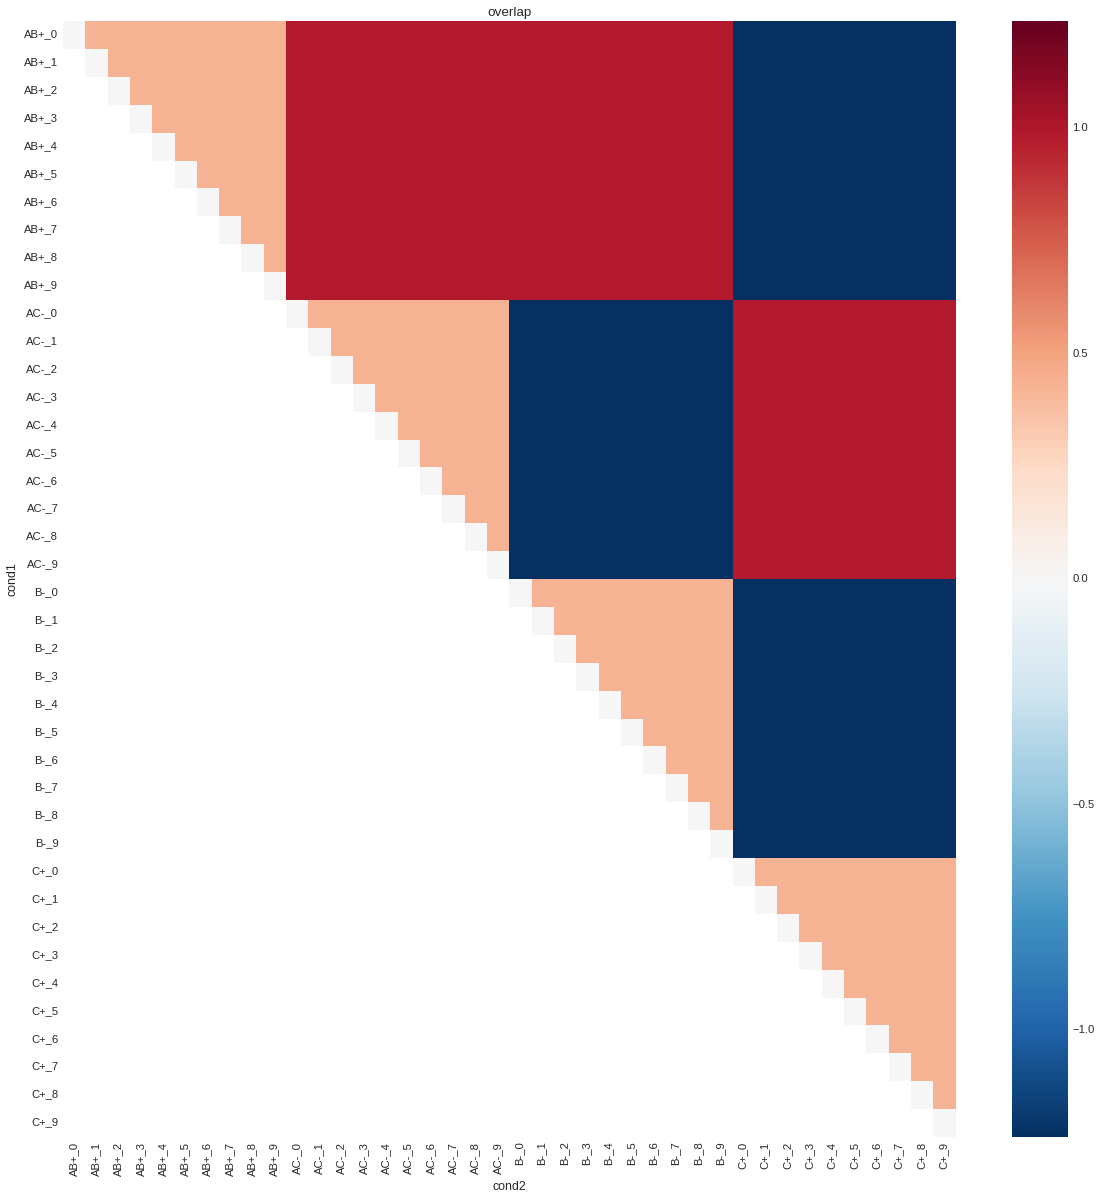

In [252]:
#Visualize regressors for the model of the RSA matrix
tmp  = mask_models['hipp']['fd_104'].copy()
tmp = tmp[tmp['run_idx'] ==3]


x_var = 'overlap'
tmp[x_var] = scipy.stats.zscore(tmp[x_var])
# tmp[x_var] = vector_reject(tmp[x_var].values, tmp['valence'].values)

plt.title('Hippocampus')
sns.set_context('paper',font_scale = 1.4,rc={"figure.figsize": (20, 20)})
sns.set_style("white")


tmp = tmp[['cond1','cond2',x_var]]
new_df = pd.DataFrame()
for cond in ['AB+_','B-_','AC-_','C+_']:
    for i in range(10):
        row = pd.DataFrame({x_var:0,
                            'cond1':cond + str(i),
                            'cond2':cond + str(i)},index = [0])
        new_df = new_df.append(row)
tmp = pd.concat([tmp,new_df])
tmp = tmp.groupby(['cond1','cond2']).mean().unstack()[x_var]
sns.heatmap(tmp)
plt.title(x_var)
plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/model_' + x_var +'.svg',dpi = 600)

# Run single trial overlap analysis

In [193]:
res = {'region':[],'sub':[], 'overlap':[], 'trial':[]}
for mask in masks:
    for sub in subs:
        m = mask_models[mask][sub].copy()

        m['run_idx'] = map(str,m['run_idx'])
        m['valence'] = scipy.stats.zscore(m['valence'])
        m['response'] = scipy.stats.zscore(m['response'])

        m['corr'] = map(np.arctanh,m['corr'])

        model = ols("corr ~ response + valence + pe + value_std + run_idx + overlap_0 + overlap_1 + overlap_2 + overlap_3 +overlap_4 + overlap_5 + overlap_6 + overlap_7 +overlap_8 + overlap_9", m)    
        fit = model.fit()

        for i in range(10):
            res['overlap'].append(fit.params['overlap_' + str(i)])
            res['sub'].append(sub)
            res['region'].append(mask)
            res['trial'].append(i)
res = pd.DataFrame(res)

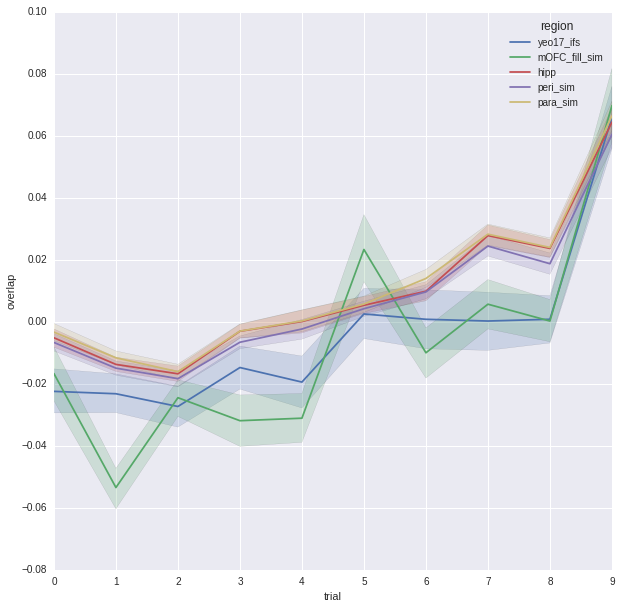

In [194]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.tsplot(value = 'overlap',time = 'trial',unit = 'sub', condition = 'region', data = res)

# Run mixed effects model

In [42]:
print masks

['V1_V2', 'hipp', 'peri_sim', 'para_sim']


In [378]:
mfx_masks = ['hipp','V1_V2']

value_regressors = ['value_next','value_std','pe','pe_unsigned']
regressors = ['response','valence','identity','overlap','pe','value_next','time','time2']
# interactions = [('identity','time')]
# for r in regressors:
#     interactions.append(('mask',r))

#set up results dataframe
res = {'intercept':[],'region':[],'sub':[],'run':[]}
for r in regressors:
    res[r] = []
for tup in interactions:
    a,b = tup
    res[a + ':' + b] = []

model = []
for mask_idx,mask in enumerate(masks):
    #deal with time
    for n,sub in enumerate(subs):
        m = mask_models[mask][sub].copy()
        m['time'] = scipy.stats.zscore(m['time'])
        m['time2'] = [x**2 for x in m['time']]
        
        #standardize regressors
        for r in regressors:
            m[r] = scipy.stats.zscore(m[r])
        
        #subjects
        m['sub'] = n
        m['mask'] = mask#mask_idx *2 - 1
        
        #clean up dataframe
        all_cols = list(regressors)
        all_cols.extend(['corr','sub','mask'])
        m = m[all_cols]

        #orthogonalize
        for v_regress in value_regressors:
            if v_regress in regressors:
                m[v_regress] = vector_reject(m[v_regress],m['response'])
                m[v_regress] = vector_reject(m[v_regress],m['valence'])

        #process y
        m['corr'] = map(np.arctanh,m['corr'])
        model.append(m.copy())
        
model = pd.concat(model)

#set up model
model_str = ['corr ~ 1']
ignore_conds = []
for tup in interactions:
    a,b = tup
    ignore_conds.extend([a,b])
    model_str.append(a + '*' + b)
for r in regressors:
    if r not in ignore_conds:
        model_str.append(r)
model_str = '+'.join(model_str)
print model_str

corr ~ 1+response+valence+identity+overlap+pe+value_next+time+time2


In [203]:
mixedfx = smf.mixedlm(model_str, model, groups = model['sub'])    
mixedfx = mixedfx.fit()
mixedfx.summary()
print mixedfx.bse_fe['mask[T.hipp]:overlap']

/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


0.000965616521922


In [379]:
def remove_intercept_variance(x, group_mean):
    return x - x.mean() + group_mean

In [380]:
model['correlation'] = model['corr']
model['corr_within'] = model.groupby('sub').correlation.transform(remove_intercept_variance,
                                                                  model.correlation.mean())
model['corr_within'] = model.groupby('mask').corr_within.transform(remove_intercept_variance,
                                                                  model.corr_within.mean())


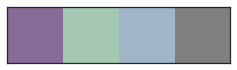

In [381]:
flatui = ["#876C97", "#A5C8B3", "#A1B6C6", "#808080"]
sns.palplot(sns.color_palette(flatui))

In [382]:
model.columns

Index([u'response', u'valence', u'identity', u'overlap', u'pe', u'value_next', u'time', u'time2', u'corr', u'sub', u'mask', u'correlation', u'corr_within'], dtype='object')

In [401]:
model_str = 'corr_within ~ 1 + response + valence + time + pe'
fit = ols(model_str,model).fit()
model['resid'] = fit.resid.values

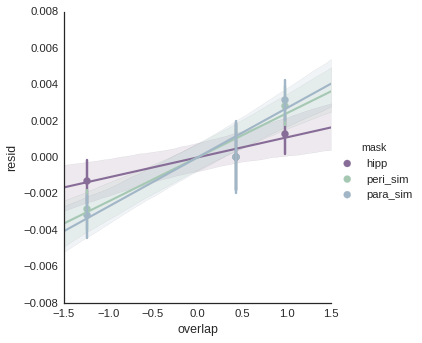

In [404]:
sub_model= model[model['mask']!='V1_V2']
sns.lmplot(y = 'resid',x= 'overlap', 
           y_partial = 'identity',
           x_bins = 3,
           x_jitter = .3,
           palette = flatui,
           hue_order = ['hipp','peri_sim','para_sim'],
           hue = 'mask', data = model)
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/mfx_slopes_' + 'overlap' +'.svg', dpi = 600)

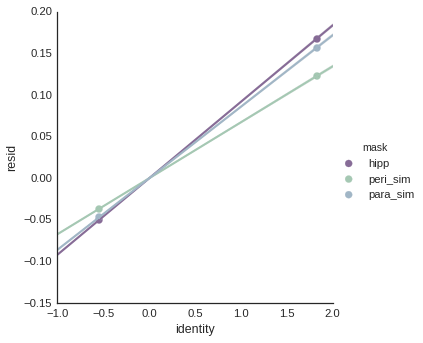

In [405]:
sub_model= model[model['mask']!='V1_V2']
sns.lmplot(y = 'resid',x= 'identity', 
           y_partial = 'overlap',
           x_bins = 5,
           x_jitter = .3,
           palette = flatui,
           hue_order = ['hipp','peri_sim','para_sim'],
           hue = 'mask', data = model)
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/mfx_slopes_' + 'overlap' +'.svg', dpi = 600)

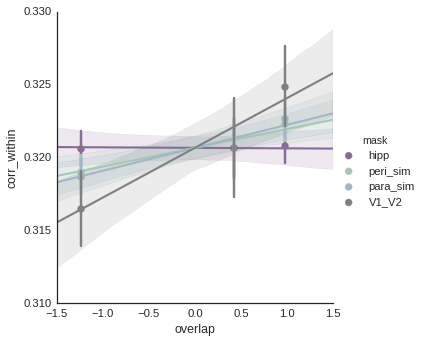

In [369]:
sns.lmplot(y = 'corr_within',x= 'overlap', 
           x_partial = 'time',
           y_partial = 'identity',
           x_bins = 3,
           x_jitter = .3,
           palette = flatui,
           hue_order = ['hipp','peri_sim','para_sim','V1_V2'],
           hue = 'mask', data = model)
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/mfx_slopes_' + 'overlap' +'.svg', dpi = 600)

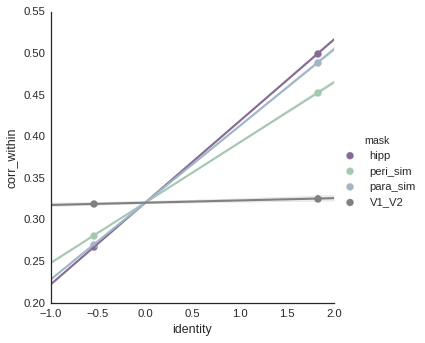

In [371]:
sns.lmplot(y = 'corr_within',
           x= 'identity',
           y_partial = 'time',
           x_bins = 5,
           palette = flatui,
           hue_order = ['hipp','peri_sim','para_sim','V1_V2'],
           hue = 'mask', 
           data = model)
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/mfx_slopes_' + 'identity' +'.svg', dpi = 600)

In [228]:
e = mixedfx.bse_fe['mask[T.para_sim]:overlap']
print 't',mixedfx.tvalues['mask[T.para_sim]:overlap']
print 'pe',mixedfx.params['mask[T.para_sim]:overlap']
print 'dz',mixedfx.params['mask[T.para_sim]:overlap']/(e * np.sqrt(len(subs)))
print 'p',mixedfx.pvalues['mask[T.para_sim]:overlap']
print mixedfx.conf_int().loc['mask[T.para_sim]:overlap']
print 

e = mixedfx.bse_fe['mask[T.para_sim]:identity']
print 't',mixedfx.tvalues['mask[T.para_sim]:identity']
print 'pe',mixedfx.params['mask[T.para_sim]:identity']
print 'dz',mixedfx.params['mask[T.para_sim]:identity']/(e * np.sqrt(len(subs)))
print 'p',mixedfx.pvalues['mask[T.para_sim]:identity']
print mixedfx.conf_int().loc['mask[T.para_sim]:identity']

t 3.18282176397
pe 0.00179586235044
dz 0.562648713153
p 0.00145847364142
0    0.000690
1    0.002902
Name: mask[T.para_sim]:overlap, dtype: float64

t -11.2004364946
pe -0.00637804057126
dz -1.97997614939
p 4.05729453997e-29
0   -0.007494
1   -0.005262
Name: mask[T.para_sim]:identity, dtype: float64


In [222]:
# mixedfx.save('/home/iballard/fd/hipp_V1V2_RSA.pkl')

In [227]:
out_f= '/home/iballard/fd/hipp_para_RSA.pkl'
pkl_file = open(out_f, 'rb')
mixedfx = pickle.load(pkl_file)
mixedfx.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                  MixedLM     Dependent Variable:     corr       
No. Observations:       146640      Method:                 REML       
No. Groups:             32          Scale:                  0.0101     
Min. group size:        3120        Likelihood:             128562.5471
Max. group size:        4680        Converged:              Yes        
Mean group size:        4582.5                                         
-----------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                   0.321    0.008   39.533 0.000  0.305  0.337
mask[T.para_sim]            0.017    0.001   33.320 0.000  0.016  0.019
identity                    0.098    0.000  244.585 0.000  0.098  0.099
mask[T.para_sim]:identity  -0.006    0.001  -11.200 0.000 -0.007 -0.005
time                       -0.043    0.000 -102.346 0.000 -0.044 -0.043
mask[T.para_sim]:time       0.001    0.001    0.907 0.364 -0.001  0.002
identity:time              -0.008    0.000  -28.627 0.000 -0.008 -0.007
response                    0.004    0.000    7.858 0.000  0.003  0.005
mask[T.para_sim]:response   0.001    0.001    2.294 0.022  0.000  0.003
valence                     0.005    0.000   10.642 0.000  0.004  0.006
mask[T.para_sim]:valence   -0.003    0.001   -4.164 0.000 -0.004 -0.001
overlap                     0.000    0.000    0.027 0.979 -0.001  0.001
mask[T.para_sim]:overlap    0.002    0.001    3.183 0.001  0.001  0.003
pe                          0.008    0.001   14.985 0.000  0.007  0.009
mask[T.para_sim]:pe         0.000    0.001    0.255 0.798 -0.001  0.002
value_std                  -0.002    0.000   -5.652 0.000 -0.003 -0.002
mask[T.para_sim]:value_std  0.000    0.001    0.742 0.458 -0.001  0.002
time2                       0.012    0.000   29.108 0.000  0.012  0.013
mask[T.para_sim]:time2      0.000    0.001    0.193 0.847 -0.001  0.001
Intercept RE                0.002    0.005                             
=======================================================================

"""

In [145]:
def run_mixed_effects(mask):
    mask_model = model.loc[mask].copy()

    mixedfx = smf.mixedlm(model_str, mask_model, groups = mask_model['sub'])    
    mixedfx = mixedfx.fit()
    
    #write to a file
    model_id = 'base'
    out_f = op.join(home_dir,'rsa','mixedfx',model_id + '_' + mask+ '.pkl')
    
    output = open(out_f, 'wb')
    pickle.dump(mixedfx, output)
    output.close() 

In [146]:
model = model.set_index('mask')

In [147]:
# run_mixed_effects('V1_V2')

In [148]:
dview = rc[0:10]
dview.block = True

dview.push(dict(home_dir=home_dir,
                model = model,
                model_str = model_str
                  ))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import nibabel as nib")
dview.execute("import pandas as pd")
dview.execute("import statsmodels.api as sm")
dview.execute("import statsmodels.formula.api as smf")
with dview.sync_imports():
    import os
    import numpy
    import scipy
    import scipy.stats
    import pickle

dview.map_sync(run_mixed_effects,masks)

importing os on engine(s)
importing numpy on engine(s)
importing scipy on engine(s)
importing scipy.stats on engine(s)
importing pickle on engine(s)


[None, None, None, None]

In [195]:
reg_map = {'hipp':'Hippocampus','para_sim':'ParaHipp', 'peri_sim':'Perirhinal','yeo17_ifs':'IFS',
           'mOFC_fill_sim':'mOFC', 'V1_V2': 'V1/V2'}
res = {'region':[],'value':[],'predictor':[],'sem':[]}
value_vars=['identity','response','valence','value_next','pe','overlap']
err = []
for m in masks:
    model_id = 'pe_valuenext'
    out_f = op.join(home_dir,'rsa','mixedfx',model_id + '_' + m + '.pkl')
    pkl_file = open(out_f, 'rb')
    mixedfx = pickle.load(pkl_file)

    for reg,val,e in zip(list(mixedfx.fe_params.keys()),
                   mixedfx.fe_params,
                  mixedfx.bse_fe):

        if reg in value_vars:
            res['region'].append(reg_map[m])
            res['predictor'].append(reg)
            res['value'].append(val)
            res['sem'].append(e)
res = pd.DataFrame(res)
pred_res = res.set_index('predictor')

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


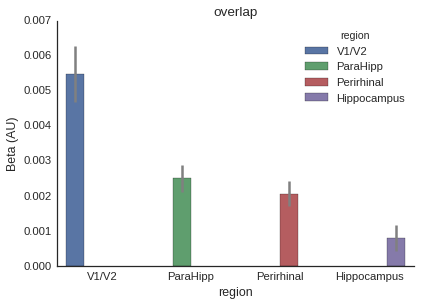

In [153]:
sns.set(rc={"figure.figsize": (10, 10)})
cond = 'overlap'
plot_res = pred_res.loc[cond]

sns.set_context('paper',font_scale = 1.4)
sns.set_style("white")

#sort dataframe
roi_plotting_order = ['V1/V2','ParaHipp','Perirhinal','Hippocampus']
plot_res['region'] = pd.Categorical(plot_res['region'],roi_plotting_order)
plot_res = plot_res.sort('region')


sns.barplot(x='region',y='value',hue = 'region',data = plot_res, 
            **{'yerr':plot_res['sem'],
            'error_kw':dict(ecolor='grey', lw=2.5)})
plt.title(cond)
plt.ylabel('Beta (AU)')
sns.set(font="Times New Roman")
sns.despine()
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/mfx_' + cond +'.png', dpi = 300)

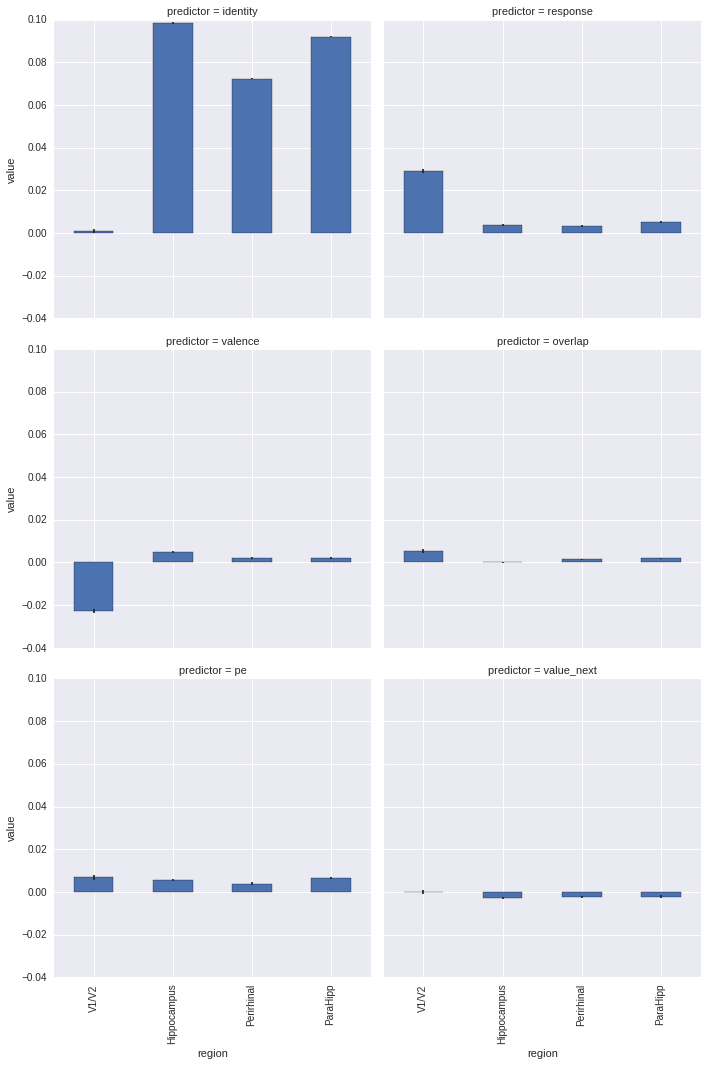

In [196]:
def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)

g = sns.FacetGrid(res,col = 'predictor',col_wrap = 2, size = 5)
g.map_dataframe(errplot, "region", "value", "sem")

# Run fixed effects model

In [372]:
value_regressors = ['value_next','value_std','pe','pe_unsigned']
regressors = ['response','valence','time','value_next','pe']
interactions = []
# interactions = [('identity','time'),('identity','time2')]
resid_df = {'sub':[],'run':[],'cond1':[],'cond2':[],'region':[],'resid':[]}

#set up results dataframe
res = {'intercept':[],'region':[],'sub':[],'run':[]}
for r in regressors:
    res[r] = []
for tup in interactions:
    a,b = tup
    res[a + ':' + b] = []

model = []
for mask_idx,mask in enumerate(masks):
    #deal with time
    for n,sub in enumerate(subs):
        m_sub = mask_models[mask][sub].copy()
        
        for run in set(m_sub['run_idx']):
            m = m_sub[m_sub['run_idx'] == int(run)].copy()
            m['time'] = scipy.stats.zscore(m['time'])
            m['time2'] = [x**2 for x in m['time']]
            
            #standardize regressors
            for r in regressors:
                m[r] = scipy.stats.zscore(m[r])

            #subjects
            m['sub'] = sub
            m['mask'] = mask
            m['run_idx'] = map(str,m['run_idx'])

#             #orthogonalize
#             m['valence'] = vector_reject(m['valence'],m['response'])
#             for v_regress in value_regressors:
#                 if v_regress in regressors:
#                     m[v_regress] = vector_reject(m[v_regress],m['response'])
#                     m[v_regress] = vector_reject(m[v_regress],m['valence'])

            #process y
            m['corr'] = map(np.arctanh,m['corr'])

            #set up model
            model_str = ['corr ~ 1']
            ignore_conds = []
            for tup in interactions:
                a,b = tup
                ignore_conds.extend([a,b])
                model_str.append(a + '*' + b)
            for r in regressors:
                if r not in ignore_conds:
                    model_str.append(r)
            model_str = '+'.join(model_str)

            #run model
            model = ols(model_str, m)    
            fit = model.fit()
            
            #populate residuals dataframe
            resid_df['resid'].extend(fit.resid)
            resid_df['run'].extend(m['run_idx'])
            resid_df['cond1'].extend(m['cond1'])
            resid_df['cond2'].extend(m['cond2'])
            resid_df['region'].extend(m['mask'])
            resid_df['sub'].extend(m['sub'])
            
            #compile results
            res['intercept'].append(fit.params['Intercept'])
            res['sub'].append(sub)
            res['region'].append(mask)
            res['run'].append(run)

            for r in regressors:
                res[r].append(fit.params[r])
            for tup in interactions:
                a,b = tup
                res[a + ':' + b].append(fit.params[a + ':' + b])
res = pd.DataFrame(res)
resid_df = pd.DataFrame(resid_df)

In [301]:
res.to_csv('/home/iballard/fd/rsa_regression_base.csv',index = False)

In [302]:
# resid_df.to_csv('/home/iballard/Dropbox/fd/rsa_time_resid.csv',index = False)
# resid_df = resid_df.set_index(['region','run','sub'])

# roi = 'hipp'
# run = 3
# sns.set(rc={"figure.figsize": (20, 20)})
# mean_rsa = resid_df.loc[roi,str(run)].groupby(['cond1','cond2']).mean()
# mean_rsa = mean_rsa.unstack()['resid']
# sns.heatmap(mean_rsa, vmax = .5)
# plt.title(roi)
# # plt.savefig('/home/iballard/Dropbox/fd/figs/' + roi + '_shuffled_covariance.png')

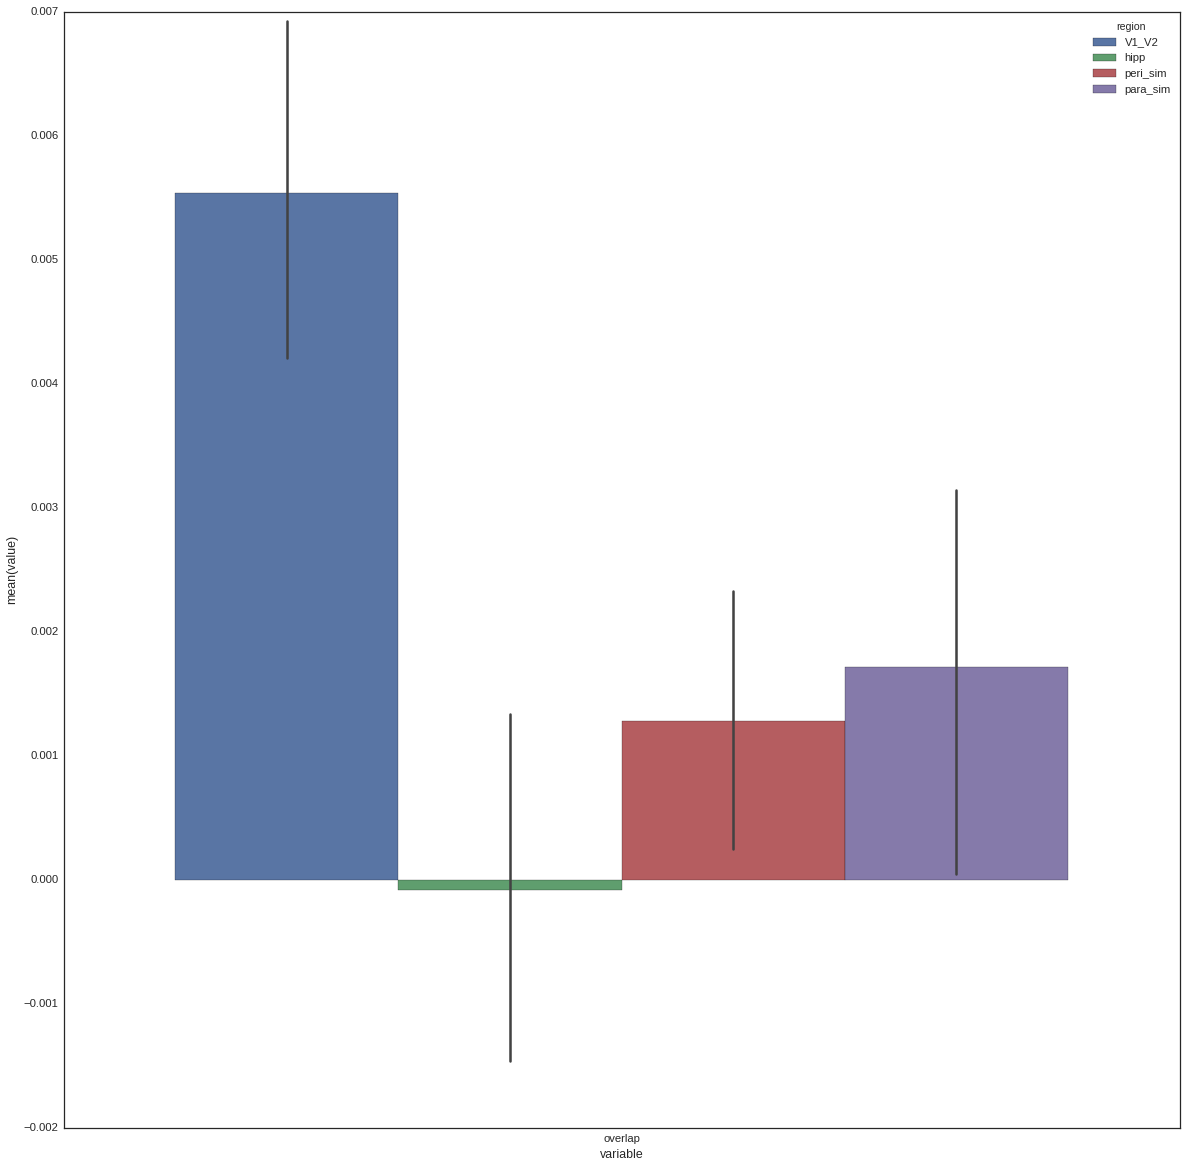

In [303]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['overlap'])
sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
# plt.savefig('/home/iballard/Dropbox/fd/figs/value_RSA.png')

# Multidimensional Scaling and Dendrogram

In [34]:
#create dataframe of residual betas
roi = 'hipp'
resid_df = []
for sub in subs:
    tmp = mask_models[roi][sub][['cond1','cond2','run_idx','resid']]
    tmp['sub'] = sub
    resid_df.append(tmp.copy())
resid_df = pd.concat(resid_df)

new_df = pd.DataFrame()
for run_idx in range(1,4):
    for cond in ['AB+_','B-_','AC-_','C+_']:
        for i in range(10):
            row = pd.DataFrame({'resid':0,
                                'run_idx':run_idx,
                                'cond1':cond + str(i),
                                'cond2':cond + str(i)},index = [0])
            new_df = new_df.append(row)
resid_df = pd.concat([resid_df,new_df])

NameError: name 'mask_models' is not defined

In [443]:
mean_rsa = resid_df[resid_df['run_idx'] == 2]
mean_rsa = mean_rsa.groupby(['cond1','cond2']).mean()['resid'].unstack()

for c1 in mean_rsa.index.values:
    for c2 in mean_rsa.index.values:
        if c1 == c2:
            mean_rsa[c1][c2] = 0
        if np.isnan(mean_rsa[c1][c2]):
            mean_rsa[c1][c2] = mean_rsa[c2][c1]
# mean_rsa = mean_rsa.values[:-1,:-1]

mds = manifold.MDS(metric = True, n_components=2, max_iter=5000, eps=1e-9, dissimilarity="precomputed", n_jobs=-1, n_init = 100000)
pos = mds.fit_transform(mean_rsa)

# Rotate the data
clf = PCA(n_components=2)
pos = clf.fit_transform(pos)

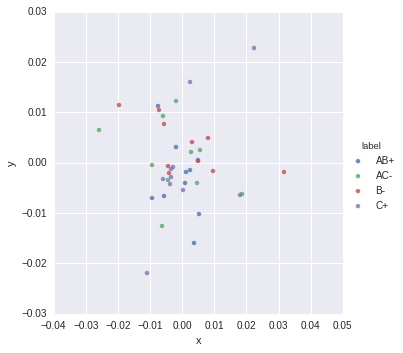

In [444]:
label = [x.split('_')[0] for x in mean_rsa.index.values]
results = pd.DataFrame({'x':pos[:,0],'y':pos[:,1],'label' :label})
sns.lmplot('x','y', hue = 'label', fit_reg = False, data = results)
plt.savefig('/home/iballard/Dropbox/fd/figs/MDS_run2_ifs_label_2.png')

In [438]:
reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

labels = mean_rsa.index.values
Vs = []
order = []
for l in labels:
    c,n = l.split('_')
    V = RL_std.loc[(2,reverse_name_map[c]),'PE'].values[int(n)]
    Vs.append(str(round(V,2)))

V_categorical = []
for v in Vs:
    if float(v) > np.percentile(map(float,Vs),75):
        V_categorical.append('+')
    elif float(v) < np.percentile(map(float,Vs),0):
        V_categorical.append('+')
    else:
        V_categorical.append('0')

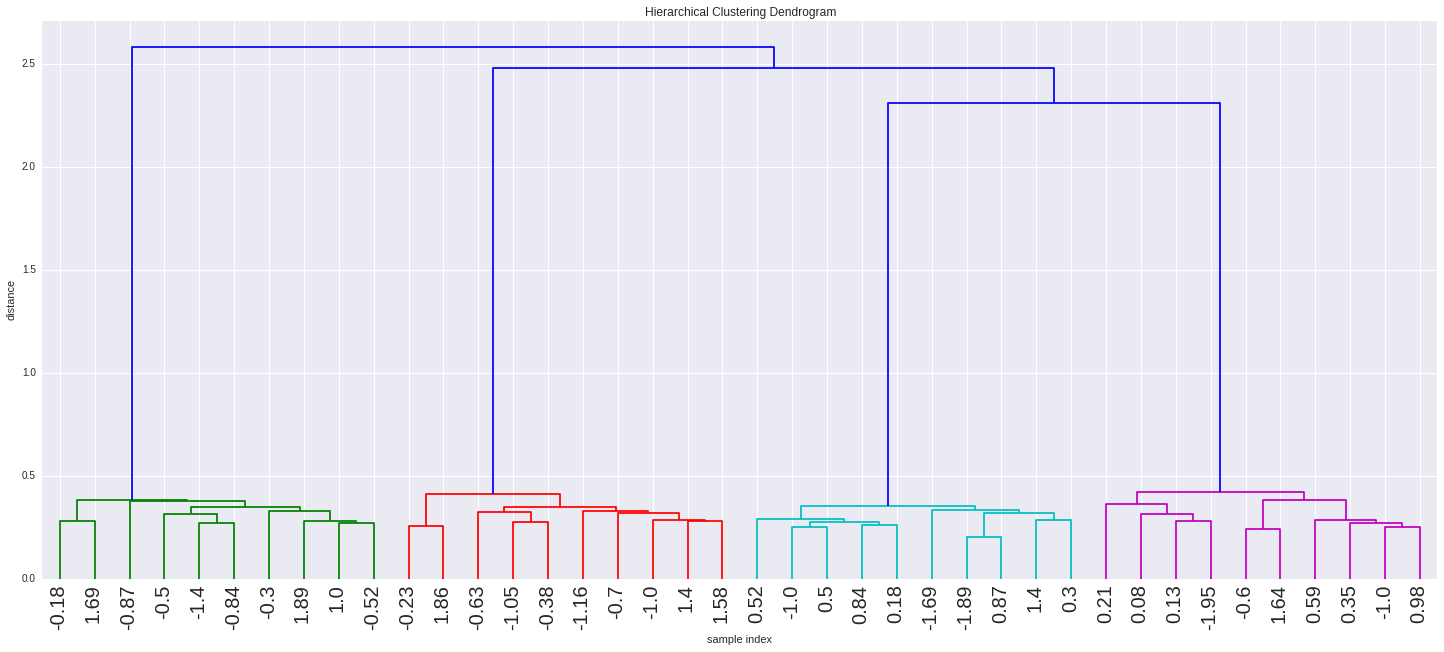

In [436]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(mean_rsa.values, 'ward')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    labels = Vs,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

In [104]:
import glob

In [117]:
for sub in subs:
    new_sub_dir = op.join(home_dir,'dti_temp',sub)
    
    dti_f = glob.glob(op.join(home_dir,'data',sub,'dti','*gz'))
    for dti in dti_f:
        new = op.join(new_sub_dir,dti.split('/')[-1])
        cmd = ['ln','-s',dti,new]
        os.system(' '.join(cmd))

# Behavioral Correlations